In [1]:
import random
random.seed(123456)

# Policy Evaluation I - Binary Treatment

Source RMD file: [link](https://docs.google.com/uc?export=download&id=1TGPxR6L12kLeXbJeJBfCpXCnRFNA3hAC)

<font color="#fa8072">Note: this chapter is in 'beta' version and may be edited in the near future.</font>

In previous chapters, you learned how to estimate the effect of a binary treatment on an outcome variable. We saw how to estimate the average treatment effect for the entire population $E[Y_i(1) - Y_i(0)]$, for specific subgroups $E[Y_i(1) - Y_i(0) | G_i]$, and at specific covariate values $E[Y_i(1) - Y_i(0)|X_i = x]$. One common feature of these quantities is that they compare the average effect of treating everyone (in the population, subgroup, etc) to the average effect of treating no one. But what if we had a _treatment rule_ that dictated who should be treated, and who should not? Would treating some people according to this rule be better than treating no one? Can we compare two possible treatment rules? Questions like these abound in applied work, so here we'll learn how to answer them using experimental and observational data (with appropriate assumptions).

Treatment rules that dictate which groups should be treatment are called **policies**. Formally, we'll define a policy (for a binary treatment) to be a mapping from a vector of observable covariates to a number in the unit interval, i.e., $\pi: x \mapsto [0,1]$. Given some vector of covariates $x$, the expression $\pi(x) = 1$ indicates a unit with this covariate value should be treated, $\pi(x) = 0$ indicates no treatment, and  $\pi(x) = p \in (0, 1)$ indicates randomization between treatment and control with probability $p$. 

There are two main objects of interest in this chapter. The first is the **value** of a policy $\pi$, defined as the average outcome attained if we assign individuals to treatments according to the policy $\pi$,

$$  E[Y_i(\pi(X_i))]. $$ 

The second object of interest is the **difference in values** between two policies $\pi$ and $\pi'$,

$$  E[Y_i(\pi(X_i)) - Y_i(\pi'(X_i))].$$

Note how the average treatment effect (ATE) we saw in previous chapters is a difference in values taking $\pi(x) \equiv 1 $ (a policy that treats everyone) and $\pi(x) \equiv 0$ (a policy that treats no one).

Importantly, in this chapter we'll be working with policies that are _pre-specified_ --- that is, that were created or decided _before_ looking at the data. In the next chapter, we'll see how to estimate a policy with desirable properties from the data.


In [2]:
from scipy.stats import uniform
from scipy.stats import binom
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statistics

## Via sample means

To fix ideas, we will begin assuming that we are in a _randomized_ setting. For concreteness, let's work with the following toy setting with two uniformly-distributed covariates and a continuous outcome.

In [3]:
n = 1000
p = 4
X = np.reshape(np.random.uniform(0,1,n*p), (n,p))
W = binom.rvs(1, p=0.5, size=n)  # independent from X and Y
Y = 0.5*(X[:,0] - 0.5) + (X[:,1] - 0.5)*W + 0.1*norm.rvs(size=n)

Here is a scatterplot of the data. Each data point is represented by a square if untreated or by a circle if treated in the eperiment. The shade of the point indicates the strength of the outcome, with more negative values being zero and more positive values being darker. 

In [4]:
y_norm = 1 - (Y - min(Y))/(max(Y) - min(Y)) # just for plotting

Text(0, 0.5, 'x2')

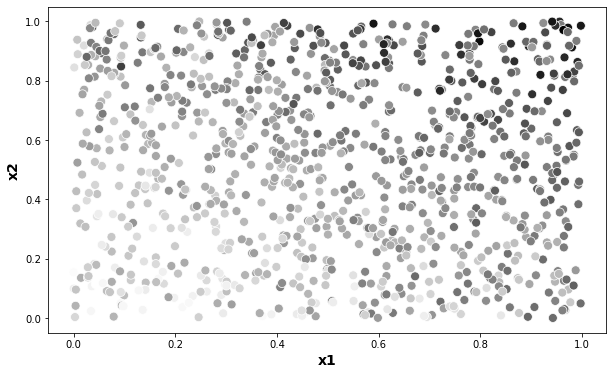

In [5]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=X[:,0], 
                y=X[:,1],
                hue = -y_norm,
                s=80,
                data=X,
               palette="Greys").legend_.remove()
plt.xlabel("x1",
            fontweight ='bold', 
            size=14)
plt.ylabel("x2", 
            fontweight ='bold',
            size=14)

Here’s a graph of each treated and untreated population separately. Remark two things about this plot. First, the covariate distribution between the two plots is the same --- which is what we should expect in a randomized setting. Second, observations with higher values of $X_2$ react positively to treatment (their blobs are darker than the untreated counterparts, which observations with lower values of $X_2$ react negatively (their blobs are lighter).

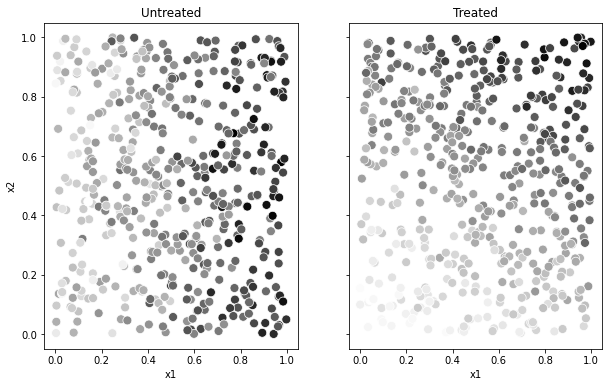

In [6]:
f, axs = plt.subplots(1,2,
                      figsize=(10,6),
                      sharey=True)
for i in range(0,2):
    aa = ["Untreated", "Treated"]
    globals()[f"ax{i}"] = sns.scatterplot(x=X[W==i,0],
                                        y=X[W==i,1],
                                        hue = -y_norm[W==i],
                                       ax=axs[i],
                                        s = 80,
                                       palette="Greys")
    globals()[f"ax{i}"].set(title=aa[i])
    globals()[f"ax{i}"].legend_.remove()
    globals()[f"ax{i}"].set(xlabel='x1', ylabel='x2')

As a first example, let's estimate the value of the following policy (assuming that it was given to or decided by us prior to looking at the data):
$$
  \pi(x) =
    \begin{cases} \tag{5.1}
     1 \quad \text{if } x_1 > .5 \text{ and } x_2 > .5 \\
     0 \quad \text{otherwise}
    \end{cases}
$$

This policy divides the plane into a "treatment" region $A$ and a complementary "no treatment" region $A^c$,
\begin{equation}
  A := \{ x : \pi(x) = 1 \} = \{x: x_{1} > .5, x_{2} > .5\}.
\end{equation}

Text(0.65, 0.7, 'TREAT (A)')

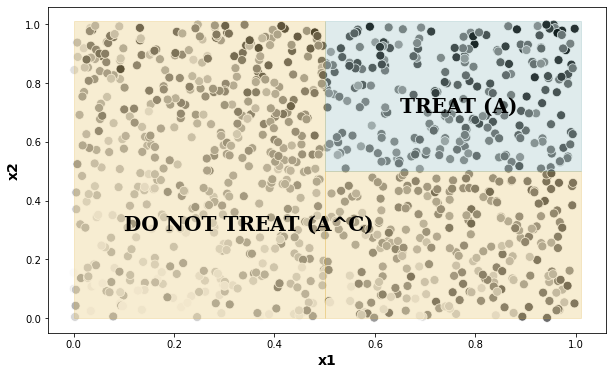

In [7]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=X[:,0], 
                y=X[:,1],
                hue = -y_norm,
                s=80,
                data=X,
               palette="Greys").legend_.remove()
plt.xlabel("x1",
            fontweight ='bold', 
            size=14)
plt.ylabel("x2", 
            fontweight ='bold',
            size=14)

plt.fill_between((0, 0.5), (1.01), 0,
                 facecolor="orange", # The fill color
                 color='goldenrod',       # The outline color
                 alpha=0.2)          # Transparency of the fill
plt.fill_between((0.5,1.01), (0.5), 0,
                 facecolor="orange", # The fill color
                 color='goldenrod',       # The outline color
                 alpha=0.2)          # Transparency of the fill
plt.fill_between((0.5,1.01), (1.01), (0.5),
                 facecolor="orange", # The fill color
                 color='cadetblue',       # The outline color
                 alpha=0.2)          # Transparency of the fill
font = {'family': 'serif',
        'color':  'BLACK',
        'weight': 'bold',
        'size': 20
        }
plt.text(0.1,0.3, 'DO NOT TREAT (A^C)', fontdict=font)
plt.text(0.65,0.7, 'TREAT (A)', fontdict=font)

We'll consider the behavior of the policy $\pi$ separately within each region. In the "treatment" region $A$, its average outcome is the same as the average outcome for the treated population.

\begin{equation} \tag{5.2}
  \begin{aligned}
    E[Y_i(\pi(X_i)) \ | \ A] 
      &= E[Y_i(1)|A]  \quad &&\text{because $\pi(x) = 1$ for all $x \in A$,} \\
      &= E[Y_i|A, W_{i}=1]  \quad &&\text{randomized setting.} \\
  \end{aligned}
\end{equation}

In the remaining region $A^c$, its average outcome is the same as the average outcome for the untreated population.

\begin{equation} \tag{5.3}
  \begin{aligned}
    E[Y_i(\pi(X_i)) \ | \ A^c] 
      &= E[Y_i(0)|A^c]  \quad &&\text{because $\pi(x) = 0$ for all $x \in A^c$,} \\
      &= E[Y_i|A, W_{i}=0]  \quad &&\text{randomized setting.} \\
  \end{aligned}
\end{equation}

The expected value of $\pi$ is a weighted average of value within each region:

\begin{align} \tag{5.4} \label{pi-pop-value}
    E[Y(\pi(X_i))] &= E[Y_i | A, W_i = 1] P(A) +  E[Y_i | A^c, W_i = 0] P(A^c), \\
\end{align}

where we denote the probability of drawn a covariate from $A$ as $P(A)$. In a randomized setting, we can estimate \eqref{pi-pop-value} by replacing population quantities by simple empirical counterparts based on sample averages; i.e., estimating $E[Y_i | A, W_i = 1]$ by the sample average of outcomes among treated individuals in region $A$, $E[Y_i | A^c, W_i = 0]$ by the sample average of outcomes among untreated individuals not in region $A$, and $P(A)$ and $P(A^c)$ by the proportions of individuals inside and outside of region $A$.

In [8]:
# Only valid in randomized setting.
A = (X[:,0] > 0.5) & (X[:,1] > 0.5)
value_estimate = np.mean(Y[A & (W==1)]) * np.mean(A) + np.mean(Y[A!=1 & (W==0)]) * np.mean(A != 1)
value_stderr = np.sqrt(np.var(Y[A & (W==1)]) / sum(A & (W==1)) * np.mean(A**2) + np.var(Y[A!=1 & (W==0)]) / sum(A!=1 & (W==0)) * np.mean(A!=1**2))
print(f"Value estimate:", value_estimate, "Std. Error", value_stderr)

Value estimate: 0.1463245415745544 Std. Error 0.01271263546282025


For another example, let's consider the value of a  _random_ policy $\pi'$ that would assign observations to treatment and control with probability $p$:

\begin{equation}
  \pi(X_i) = Z_i \qquad Z_i \sim^{iid} \text{Binomial}(p).
\end{equation}

To identify the value of this policy, follow the same argument as above. However, instead of thinking in terms of "regions", consider the output of the random variable $Z_i$:

\begin{equation} \label{region-a}
  \begin{aligned}
    E[Y_i(\pi'(X_i)) \ | \ Z_i = 1]
      &= E[Y_i(1)| Z_i = 1] \quad &&\text{because $\pi'(\cdot) = 1$ when $Z_i = 1$,} \\ 
      &= E[Y_i(1)]          \quad &&\text{$Z_i$ is drawn independently,} \\
      &= E[Y_i| W_{i}=1]  \quad &&\text{randomized setting.} \\
  \end{aligned}
\end{equation}

We can proceed similarly for the case of $Z_i = 0$. Finally, since $P(Z_i = 1) = p$,

\begin{equation}  \tag{5.5}
  E[Y_i(\pi'(X_i))] = pE[Y_i | W_i=1] + (1-p)E[Y_i | W_i = 0],
\end{equation}

which in a randomized setting can be estimated in a manner analogous to the previous example.

In [9]:
# Only valid in randomized setting.
p = 0.75 # for example
value_estimate = p * np.mean(Y[W==1]) + (1-p) * np.mean(Y[W==0]) 
value_stderr = np.sqrt(np.var(Y[W==1]) / sum(W==1) * p**2 + np.var(Y[W==0]) / sum(W==0))
print(f"Value estimate:", value_estimate, "Std. Error", value_stderr)

Value estimate: 0.022507517188991265 Std. Error 0.01369786804334294


### Estimating difference in values

Next, let's estimate the difference in value between two given policies. For a concrete example, let’s consider the gain from switching to $\pi$ defined in (5.1) from a policy $\pi''$ that never treats, i.e., $\pi''(X_i) \equiv 0$. That is, 

\begin{equation} \tag{5.6} \label{diff-0}
  E[Y(\pi(X_i)) - Y(\pi''(X_i))].
\end{equation}

We already derived the value of $\pi$ in (5.5). To derive the value of the second policy,

\begin{align} \tag{5.7} \label{ey0-expand}
  &E[Y(\pi''(X_i))] \\ 
    &= E[Y_i(0)] && \text{$\pi''(x) = 0$ for all $x$,}  \\
    &= E[Y_i(0)|A]P(A) + E[Y_i(0)|A^c]P(A^c) && \text{law of total expectation,} \\
    &= E[Y|A,W=0]P(A) + E[Y|A^c,W=0]P(A^c) &&\text{randomized setting.} 
\end{align}

Substituting (5.5) and \eqref{ey0-expand} into \eqref{diff-0} and simplifying,

\begin{equation} \tag{5.8} \label{diff-0-result}
  E[Y(\pi(X_i)) - Y(\pi''(X_i))]
    = \left( E[Y_i|A, W_i=1] - E[Y_i|A,W_i=0] \right) \cdot P(A) + 0 \cdot P(A^c) 
\end{equation}

Expression \eqref{diff-0-result} has the following intepretation. In region $A$, the policy  $\pi$ treats, and the "never treat" policy does not; thus the gain in region $A$ is the average treatment effect in that region, $E[Y_i(1) - Y_i(0)|A]$, which in a randomized setting equals the first term in parentheses. In region $A^{c}$, the policy $\pi$ does not treat, but neither does the "never treat" policy. Therefore, there the different is exactly zero. The expected difference in values equals the weighted average of the difference in values within each region.

In [10]:
# Only valid in randomized settings.
A = (X[:,0] > 0.5) & (X[:,1] > 0.5)
diff_estimate = (np.mean(Y[A & (W==1)]) - np.mean(Y[A & (W==0)])) * np.mean(A)
diff_stderr = np.sqrt(np.var(Y[A & (W==1)]) / sum(A & (W==1)) + np.var(Y[A & (W==0)]) / sum(A & W==0)) * np.mean(A)**2
print(f"Difference estimate:", diff_estimate, "Std. Error:", diff_stderr)

Difference estimate: 0.05486860334910536 Std. Error: 0.0010107854403380125


For another example, let's consider the difference in value between $\pi$ and a _random_ policy $\pi'$ that assigns observations to treatment and control with equal probability $p = 1/2$. We have already derived an expression for value of the random policy in (5.5). Subtracting it from the value of the policy $\pi$ derived in (5.4) and simplifying,

\begin{align} \label{pi-pip-diff-results} \tag{5.9}
  E[Y(\pi) - Y(\pi'(X_i))] 
    &= \frac{P(A)}{2} \left( E[Y_i(1) - Y_i(0) | A] \right) +
      \frac{P(A^c)}{2} \left( E[Y_i(0) - Y_i(1) | A^c] \right) 
\end{align}

Here's how to interpret \eqref{pi-pip-diff-results}. In region $A$, policy $\pi$ treats everyone, obtaining average value $E[Y_i(1)|A]$; meanwhile, policy $\pi'$ treats half the observations (i.e., it treats each individual with one-half probability), obtaining average value $(E[Y_i(1) + Y_i(0)|A])/2$. Subtracting the two gives the term multiplying $P(A)$ in \eqref{pi-pip-diff-results}. In region $A^c$, policy $\pi$ treats no one, obtaining average value $E[Y_i(0)|A]$; meanwhile, policy $\pi'$ still obtains $(E[Y_i(1) + Y_i(0)|A^c])/2$ for the same reasons as above. Subtracting the two gives the term multiplying $P(A^c)$ \eqref{pi-pip-diff-results}. Expression \eqref{pi-pip-diff-results} is the average of these two terms weighted by the size of each region. 

Finally, in a randomized setting, \eqref{pi-pip-diff-results} is equivalent to

\begin{align}
\frac{P(A)}{2} \left( E[Y|A,W=1] - E[Y|A,W=0] \right) + 
        \frac{P(A^c)}{2} \left( E[Y|A^c,W=0] - E[Y|A,W=1] \right),
\end{align}
which suggests an estimator based on sample averages as above.

In [11]:
# Only valid in randomized settings.
A = (X[:,0] > 0.5) & (X[:,1] > 0.5)
diff_estimate = (np.mean(Y[A & (W==1)]) - np.mean(Y[A & (W==0)])) * np.mean(A) / 2 + (np.mean(Y[A!=1 & (W==0)]) - np.mean(Y[A!=1 & (W==1)])) * np.mean(A!=1) / 2
diff_stderr = np.sqrt((np.mean(A)/2)**2 * (np.var(Y[A & (W==1)])/sum(A & (W==1)) + np.var(Y[A & (W==0)])/sum(A & (W==0))) + (np.mean(A!=1)/2)**2 * (np.var(Y[A!=1 & (W==1)])/sum(A!=1 & (W==1)) + np.var(Y[A!=1 & (W==0)])/sum(A!=1 & (W==0))))
print(f"Difference estimate:", diff_estimate, "Std. Error:", diff_stderr)

Difference estimate: 0.0671869798992261 Std. Error: 0.006761551310009502


### Via AIPW scores

In this section, we will use the following simulated _observational_ setting. Note how the probability of receiving treatment varies by individual, but it depends only on observable characteristics (ensuring unconfoundedness) and it is bounded away from zero and one (ensuring overlap). We assume that assignment probabilities are not known to the researcher.

In [12]:
# An "observational" dataset satisfying unconfoundedness and overlap.
n = 1000
p = 4
X = np.reshape(np.random.uniform(0,1,n*p), (n,p))
e = 1/(1+np.exp(-2*(X[:,0]-.5)-2*(X[:,1]-.5)))  # not observed by the analyst.
W = binom.rvs(1, p=e, size=n)  
Y = 0.5*(X[:,0] - 0.5) + (X[:,1] - 0.5)*W + 0.1*norm.rvs(size=n)

The next plot illustrates how treatment assignment isn’t independent from observed covariates. Individuals with high values of $X_{i,1}$ and $X_{i,2}$ are more likely to be treated and to have higher outcomes. 

In [13]:
y_norm = (Y - min(Y))/(max(Y) - min(Y))

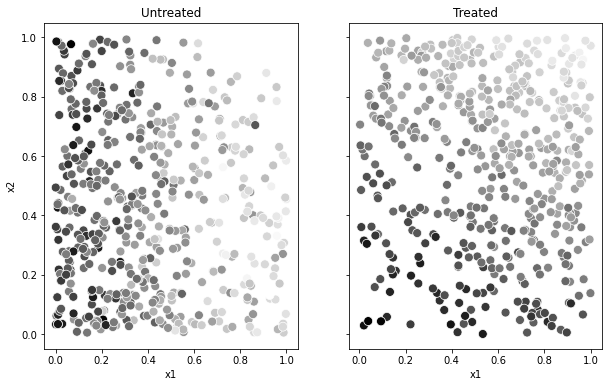

In [14]:
f, axs = plt.subplots(1,2,
                      figsize=(10,6),
                      sharey=True)
for i in range(0,2):
    aa = ["Untreated", "Treated"]
    globals()[f"ax{i}"] = sns.scatterplot(x=X[W==i,0],
                                        y=X[W==i,1],
                                        hue = -y_norm[W==i],
                                       ax=axs[i],
                                        s = 80,
                                       palette="Greys")
    globals()[f"ax{i}"].set(title=aa[i])
    globals()[f"ax{i}"].legend_.remove()
    globals()[f"ax{i}"].set(xlabel='x1', ylabel='x2')

<font size=1>
If we "naively" used the estimators based on sample averages above, the policy value estimate would be biased. Would the bias be upward or downward?
</font>

In randomized setting and observational settings with unconfoundedness and overlap, there exists estimates of policy values and differences that are more efficient (i.e., they have smaller variance in large samples) than their counterparts based on sample averages. These are based on the _AIPW scores_ that we studied in previous chapters. For example, to estimate the $E[Y_i(1)]$

\begin{align} \tag{5.10} \label{gamma-1}
  \hat {\Gamma}_{i,1}
    &= \hat{\mu}^{-i}(X_i, 1) + \frac{W_i}{\hat{e}^{-i}(X_i)} \left(Y_i -\hat{\mu}^{-i}(X_i, 1)\right) 
\end{align}

As we discussed in the chapter on ATE, averaging over AIPW scores \eqref{gamma-1} across individuals yields an unbiased / consistent estimator of $\E[Y_i(1)]$ provided that at least one of $\hat{\mu}^{-i}(x, 1)$ or $\hat{e}^{-i}(x)$ is an unbiased / consistent estimator of the outcome model $\mu(x,w) := E[Y_i(w)|X_i=x]$ or propensity model $e(x) := P[W_i=1|X_i=x]$. Provided that these are estimates using non-parametric methods like forests or neural networks, consistency should be guaranteed, and in addition the resulting estimates should have smaller asymptotic variance. Therefore, barring computational issues, AIPW-based estimates are usually superior to estimates based on sample means, even in randomized settings (though, for completeness, the latter should still be reported when valid).

For the control, we have the following estimator based on AIPW scores,

\begin{align} \tag{5.11}  \label{gamma-0}
  \hat {\Gamma}_{i,0} 
    &= \hat{\mu}^{-i}(X_i, 0) + \frac{1-W_i}{1-\hat{e}^{-i}(X_i)} \left(Y_i -\hat{\mu}^{-i}(X_i, 0)\right).
\end{align}

To estimate the value of a binary policy $\pi$, we average over AIPW scores, selecting \eqref{gamma-1} or \eqref{gamma-0} for each individual depending on whether the policy dictates that the individual should be treated or not. That is, we estimate the value of a policy $\pi$ via the following average,

\begin{align} 
  \frac{1}{n} \sum_{i=1}^n \hat {\Gamma}_{i,\pi(X_i)} 
  \qquad  
  \hat {\Gamma}_{i,\pi(X_i)} := \pi(X_i) \hat {\Gamma}_{i,1} + (1 - \pi(X_i)) \hat {\Gamma}_{i,0}.
\end{align}

The next snippet construct AIPW scores via causal forests. 

In [15]:
# !pip install econml

In [16]:
import econml
# Main imports
from econml.orf import DMLOrthoForest, DROrthoForest
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso, WeightedLassoCV
from sklearn.linear_model import MultiTaskLassoCV
# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from econml.grf import RegressionForest
%matplotlib inline
import patsy
import seaborn as sns

In [17]:
# Valid in observational and randomized settings

# Randomized settings: use the true assignment probability:

# Estimate a causal forest.
# Observational settings with unconfoundedness + overlap:
forest = CausalForestDML(model_t=RegressionForest(),  
                       model_y=RegressionForest(),
                       n_estimators=200, min_samples_leaf=5,
                       max_depth=50,
                       verbose=0, random_state=123)

In [18]:
forest.tune(Y, W, X=X)
forest.fit(Y, W, X=X)

In [19]:
# Estimate a causal forest
tau_hat = forest.effect(X=X) # tau(X) estimates

# Get residuals  and propensity 
residuals = forest.fit(Y, W, X=X, cache_values=True).residuals_
W_res = residuals[1]
W_hat = W - W_res 
Y_res = residuals[0]
Y_hat = Y - Y_res

# T = beta_hat*X + e , beta_hat*X = T_hat = T-e

In [20]:
# Estimate outcome model for treated and propen
mu_hat_1 = Y_hat + (1 - W_hat) * tau_hat # E[Y|X,W=1] = E[Y|X] + (1-e(X))tau(X)
mu_hat_0 = Y_hat - W_hat * tau_hat  # E[Y|X,W=0] = E[Y|X] - e(X)tau(X)

# Compute AIPW scores
gamma_hat_1 = mu_hat_1 + W/W_hat * (Y - mu_hat_1)
gamma_hat_0 = mu_hat_0 + (1-W)/(1-W_hat) * (Y - mu_hat_0)

Once we have computed AIPW scores, we can compute the value of any policy. Here's how to estimate the value of (5.1).

In [21]:
# Valid in observational and randomized settings
pi = (X[:,0] > .5) & (X[:,1] > .5)
gamma_hat_pi = pi * gamma_hat_1 + (1 - pi) * gamma_hat_0
value_estimate = np.mean(gamma_hat_pi)
value_stderr = np.std(gamma_hat_pi) / np.sqrt(len(gamma_hat_pi))
print(f"Value estimate:", value_estimate, "Std. Error:", value_stderr)

Value estimate: 0.04909281018025912 Std. Error: 0.008388507000715159


The next snippet estimates the value of a random policy that treats with 75\% probability.

In [22]:
# Valid in observational and randomized settings
pi_random = 0.75
gamma_hat_pi = pi_random * gamma_hat_1 + (1 - pi_random) * gamma_hat_0
value_estimate = np.mean(gamma_hat_pi)
value_stderr = np.std(gamma_hat_pi) / np.sqrt(len(gamma_hat_pi))
print(f"Value estimate:", value_estimate, "Std. Error:", value_stderr)

Value estimate: -0.005643484970411176 Std. Error: 0.008956961106423536


To estimate the difference in value between two policies $\pi$ and $\tilde{\pi}$, simply subtract the scores,
\begin{align}
  \frac{1}{n} \sum_{i=1}^n \hat {\Gamma}_{i,\pi(X_i)} - \hat {\Gamma}_{i,\tilde{\pi}(X_i)}.
\end{align}

For example, here we estimate the difference between policy and the "never treat" policy.

In [23]:
# Valid in randomized settings and observational settings with unconfoundedness + overlap

# AIPW scores associated with first policy
pi = (X[:,0] > .5) & (X[:,1] > .5)
gamma_hat_pi = pi * gamma_hat_1 + (1 - pi) * gamma_hat_0

# AIPW scores associated with second policy
pi_never = 0
gamma_hat_pi_never = pi_never * gamma_hat_1 + (1 - pi_never) * gamma_hat_0

# Difference
diff_scores = gamma_hat_pi - gamma_hat_pi_never 
diff_estimate = np.mean(diff_scores)
diff_stderr = np.std(diff_scores) / np.sqrt(len(diff_scores))
print(f"Diff estimate:", diff_estimate, "Std. Error:", diff_stderr)

Diff estimate: 0.06183896491449065 Std. Error: 0.005503825578682608


## Case study

For completeness we'll close out this section by estimating policy values using real data. Again, we'll use an abridged version of the General Social Survey (GSS) [(Smith, 2016)](https://gss.norc.org/Documents/reports/project-reports/GSSProject%20report32.pdf) dataset that was introduced in the previous chapter. In this dataset, individuals were sent to treatment or control with equal probability, so we are in a randomized setting. 

<font size=2>
(Please note that we have inverted the definitions of treatment and control)
</font>

In [24]:
import  csv
import pandas as pd

In [25]:
# Read in data
url = 'https://drive.google.com/file/d/1kSxrVci_EUcSr_Lg1JKk1l7Xd5I9zfRC/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
data = pd.read_csv(path)
n = len(data)

# NOTE: We'll invert treatment and control, compared to previous chapters
data['w'] = 1 - data['w']

# Treatment is the wording of the question:
# 'does the the gov't spend too much on 'assistance to the poor' (control: 0)
# 'does the the gov't spend too much on "welfare"?' (treatment: 1)
treatment = data['w']

# Outcome: 1 for 'yes', 0 for 'no'
outcome = data['y']

# Additional covariates
covariates = ["age", "polviews", "income", "educ", "marital", "sex"]

We'll take the following policy as an example. It asks individuals who are older (age > 50) or more conservative (`polviews` $\leq$ 4) if they think the government spends to much on "welfare", and it asks yonger and more liberal individuals if they think the government spends too much on "assistance to the poor".

\begin{equation} \tag{5.12} \label{polage}
  (\#eq:polage)
  \pi(x) =
    \begin{cases}
      1 \qquad \text{if }\texttt{polviews} \leq 4 \text{ OR } \texttt{age } > 50  \\
      0 \qquad \text{otherwise}
    \end{cases}
\end{equation}

We should expect that a higher number of individuals will answer 'yes' because, presumably, older and more conservative individuals in this sample may be more likely to be against welfare in the United States. 

We selected policy \eqref{polage} purely for illustrative purposes, but it's not hard to come up with examples where understanding how to word certain questions and prompts can be useful. For example, a non-profit that champions assistance to the poor may be able to obtain more donations if they advertise themselves as champions of "welfare" or "assistance to the poor" to different segments of the population.

Since this is a randomized setting, we can estimate its value via sample averages.

In [26]:
# Only valid in randomized setting
X = data[covariates]
Y = data['y']
W = data['w']
  
pi = (X["polviews"] <= 4) | (X["age"] > 50)
A = (pi == 1)
value_estimate = np.mean(Y[A & (W==1)]) * np.mean(A) + np.mean(Y[A!=1 & (W==0)]) * np.mean(A != 1)
value_stderr = np.sqrt(np.var(Y[A & (W==1)]) / sum(A & (W==1)) * np.mean(A**2) + np.var(Y[A!=1 & (W==0)]) / sum(A!=1 & (W==0)) * np.mean(A!=1**2))
print(f"Value estimate:", value_estimate, "Std. Error", value_stderr)

Value estimate: 0.3964638929438347 Std. Error 0.004662935913749193


The result above suggests that if we assign older and more conservative individuals about "welfare", and other individuals about "assistance to the poor", then on average about 34.6% of individuals respond 'yes'.  

The next snippet uses AIPW-based estimates, which would also have been valid had the data been collected in an observational setting with unconfoundedness and overlap.

In [27]:
# Valid in randomized settings and observational settings with unconfoundedness + overlap
fmla = '0+age+polviews+income+educ+marital+sex'
desc = patsy.ModelDesc.from_formula(fmla)
desc.describe()
matrix = patsy.dmatrix(fmla, data, return_type = "dataframe")

T = data.loc[ : ,"w"]
Y = data.loc[ : ,"y"]
X = matrix
W = None 

# Estimate a causal forest
# Important: comment/uncomment as appropriate.
# Randomized setting (known, fixed assignment probability)
forest = CausalForestDML(model_t=RegressionForest(),
                       model_y=RegressionForest(),
                       n_estimators=200, min_samples_leaf=5,
                       max_depth=50,
                       verbose=0, random_state=123)

forest.tune(Y, T, X=X, W=W)
forest.fit(Y, T, X=X, W=W)


# Estimate a causal forest
tau_hat = forest.effect(X=X) # tau(X) estimates

# Get residuals  and propensity 
residuals = forest.fit(Y, T, X=X, cache_values=True).residuals_
T_res = residuals[1]
T_hat = T - T_res 
Y_res = residuals[0]
Y_hat = Y - Y_res

# Estimate outcome model for treated and propen
mu_hat_1 = Y_hat + (1 - T_hat) * tau_hat # E[Y|X,W=1] = E[Y|X] + (1-e(X))tau(X)
mu_hat_0 = Y_hat - T_hat * tau_hat  # E[Y|X,W=0] = E[Y|X] - e(X)tau(X)

# Compute AIPW scores
gamma_hat_1 = mu_hat_1 + T/T_hat * (Y - mu_hat_1)
gamma_hat_0 = mu_hat_0 + (1-T)/(1-T_hat) * (Y - mu_hat_0)

As expected, the results are very similar (as they should be since they are both valid in a randomized seting).

In [28]:
# Valid in randomized settings and observational settings with unconfoundedness + overlap
gamma_hat_pi = pi * gamma_hat_1 + (1 - pi) * gamma_hat_0
value_estimate = np.mean(gamma_hat_pi)
value_stderr = np.std(gamma_hat_pi) / np.sqrt(len(gamma_hat_pi))
print(f"Value estimate:", value_estimate, "Std. Error:", value_stderr)

Value estimate: 0.35221836694529596 Std. Error: 0.004051622185299656


The next snippet estimates the value of policy (5.12) and a random policy that assigns to treatment and control with equal probability. 

In [29]:
# Valid in randomized settings and observational settings with unconfoundedness + overlap
pi_2 = 0.5

gamma_hat_pi_1 = pi * gamma_hat_1 + (1 - pi) * gamma_hat_0
gamma_hat_pi_2 = pi_2 * gamma_hat_1 + (1 - pi_2) * gamma_hat_0
gamma_hat_pi_diff = gamma_hat_pi_1 - gamma_hat_pi_2
diff_estimate = np.mean(gamma_hat_pi_diff)
diff_stderr = np.std(gamma_hat_pi_diff) / np.sqrt(len(gamma_hat_pi_diff))
print(f"Difference estimate:", diff_estimate, "Std. Error:", diff_stderr)

Difference estimate: 0.08580153013260283 Std. Error: 0.002588590468228363


The result suggests that assigning observations to treatment as in (5.12) produces 8\% more positive responses than assigning individuals at uniformly at random. 

## Further reading

[Athey and Wager (2020, Econometrica)](https://arxiv.org/abs/1702.02896) has a good review of the literature on policy learning and evaluation. For a more accessible introduction to the theory, see
[Stefan Wager's lecture notes](https://web.stanford.edu/~swager/stats361.pdf), lecture 7. However, both references focus heavily on policy learning, which will be the topic of the next chapter.